# Notebook to identify neural invariances with CPPN with 2d latent space

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm import tqdm
import wandb
from classicalv1.toy_models import RotationInvariantGabor, RotationInvariantComplex, ComplexCell
from invariance_generation.datamodule import JitteringGridDatamodule
from invariance_generation.cppn import CPPNForInvariances
from invariance_generation.regularization import SimCLROnGrid
from invariance_generation.utils.plot_utils import plot_f, plot_filters
from invariance_generation.utils.misc import prepare_video
import os
import math
from PIL import Image
import glob
import matplotlib
font = {'size'   : 20}


matplotlib.rc('font', **font)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [31]:
random_seed = 42
with_periodic_invariances = True # chose among: False True 
blow_up = False # choose among: True False
temperature =  0.3
reg_coefs = [1, 0.5]
epochs_per_reg = 100
lr = 1e-2


In [32]:
np.random.seed(random_seed)
torch.manual_seed(random_seed)

---

## Initialize the neuron model

In [33]:
neuron_config = {
        'res': [30, 30],
        'n_thetas': 180,
        'pos': [0, 0],
        'max_angle': 2*np.pi
    }
encoding_model = RotationInvariantComplex(**neuron_config).to(device)
MEI_activation = 32.566429138183594

## Re-parametrized image generation via CPPN

In [ ]:
cppn_config = dict(    
    img_res=[30,30],
    channels=1,
    positional_encoding_dim=10,
    positional_encoding_projection_scale=1.,
    num_neurons=1,
    num_invariances=1,
    with_periodic_invariances=with_periodic_invariances,
    nonlinearity=nn.LeakyReLU,
    weights_scale=.1,
    batchnorm=True,
    bias=True,
    aux_dim_scale=1.
)
cppn = CPPNForInvariances(**cppn_config).to(device)
cppn


Number of neurons = 1
Embedding dims = 0
Invariance dims = 1
Periodicity = [True]
single image shape = [1, 30, 30]
CPPNForInvariances(
  (cppn_generator): CPPNGenerator(
    (func): Sequential(
      (layer0): Linear(in_features=22, out_features=15, bias=True)
      (batchnorm0): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (nonlinearity0): LeakyReLU(negative_slope=0.01)
      (layer1): Linear(in_features=15, out_features=15, bias=True)
      (batchnorm1): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (nonlinearity1): LeakyReLU(negative_slope=0.01)
      (layer2): Linear(in_features=15, out_features=15, bias=True)
      (batchnorm2): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (nonlinearity2): LeakyReLU(negative_slope=0.01)
      (layer3): Linear(in_features=15, out_features=15, bias=True)
      (batchnorm3): BatchNorm1d(15, eps=1e-05, momentum=0.1, affine=True

## Intermediate img transformation

In [ ]:
class FixMeanStd(nn.Module):
    def __init__(self, mean=None, std=None, eps=1e-12):
        super().__init__()
        self.mean = mean
        self.std = std
        self.eps = eps
    def forward(self, img):
        if self.mean is not None:
            img_mean = img.mean(dim=(2, 3), keepdim=True)
            img1 = self.mean + img - img_mean
        else:
            img1 = img
        if self.std is not None:        
            img_std = img1.std(dim=(2, 3), keepdim=True)
            img2 = self.std * img1 / (img_std + self.eps)
        return img2

class NoTransform(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

In [ ]:
img_trans_config = dict(mean=0, std=.2)
img_transforms = FixMeanStd(**img_trans_config).to(device)

## Dataloader to load latent grid points

In [ ]:
dataloader_config = dict(
    num_invariances=1,
    grid_points_per_dim=100, 
    steps_per_epoch=100, 
)
dm = JitteringGridDatamodule(**dataloader_config)
dm.train_dataloader()
grid = dm.grid.to(device)

## Constrastive learning objective

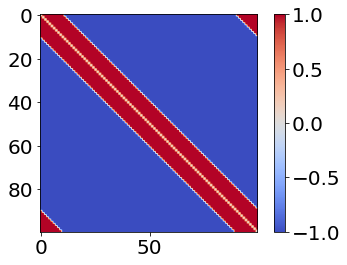

In [ ]:
objective_config = dict(
    num_invariances=1,
    grid_points_per_dim=100,
    neighbor_size=.1,
    temperature = temperature,
    with_periodic_invariances=with_periodic_invariances,
    with_round_neighbor = False
)

grid_reg = SimCLROnGrid(**objective_config).to(device)
ax = plot_f(grid_reg.neighbor_mask, return_plt=True)

## Output function

In [ ]:
def forward(grid, cppn, img_tranfs, encoding_model, resolution_increase_factor=1.):
    """forward pass throught the pipeline """
    img_pre = cppn(grid)
    img_post = img_tranfs(img_pre)
    acts = encoding_model(img_post)
    
    if resolution_increase_factor > 1:
        with torch.no_grad():
            img_pre_hres = cppn(grid, img_res=[r*resolution_increase_factor for r in cppn.img_res])
            img_post_hres = img_transforms(img_pre_hres)       
    else:
        img_post_hres = img_post
    
    return img_pre, img_post, acts, img_post_hres

In [ ]:

if MEI_activation is None:
    num_epochs = 20
    optimizer = torch.optim.Adam(cppn.parameters(), lr=lr)

    pbar = tqdm(range(num_epochs), desc='mean activation will appear after one epoch')
    encoding_model.eval()

    activations = []
    for epoch in pbar:

        # Training
        cppn.train()
        for input_grid in dm.train_dataloader():
            input_grid = input_grid.to(device)
            img_pre, img_post, _acts, _ = forward(input_grid, cppn, img_transforms, encoding_model)
            acts = _acts
            loss = -acts.mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        pbar.set_description(f"act = {acts.mean().item()}")
        activations.append(acts.mean().item())

    cppn.eval()    
    with torch.no_grad():
        img_pre, img_post, acts, img_post_hr = forward(grid, cppn, img_transforms, 
                                                       encoding_model, resolution_increase_factor=3)
        fig, ax = plot_filters(img_post_hr, nrow=int(np.sqrt(grid.shape[0])))
        ax.set(xticks=[], yticks=[], title=f"Epcoh {epoch+1}/{num_epochs}");
        plt.show()

## Train the generative model (logging with wandb)

In [ ]:
config = {
    "random_seed": random_seed,
    "neuron_config": [],
    "MEI_activation": MEI_activation,
    "cppn_config": cppn_config, 
    "img_trans_config": img_trans_config, 
    "dataloader_config": dataloader_config, 
    "objective_config": objective_config,
    "training_config": {"reg_coefs": reg_coefs, 
                        "epochs_per_reg": epochs_per_reg,}
}
config

{'random_seed': 42,
 'neuron_config': [],
 'MEI_activation': 32.566429138183594,
 'cppn_config': {'img_res': [30, 30],
  'channels': 1,
  'positional_encoding_dim': 10,
  'positional_encoding_projection_scale': 1.0,
  'num_neurons': 1,
  'num_invariances': 1,
  'with_periodic_invariances': True,
  'nonlinearity': torch.nn.modules.activation.LeakyReLU,
  'weights_scale': 0.1,
  'batchnorm': True,
  'bias': True,
  'aux_dim_scale': 1.0},
 'img_trans_config': {'mean': 0, 'std': 0.2},
 'dataloader_config': {'num_invariances': 1,
  'grid_points_per_dim': 100,
  'steps_per_epoch': 100},
 'objective_config': {'num_invariances': 1,
  'grid_points_per_dim': 100,
  'neighbor_size': 0.1,
  'temperature': 0.3,
  'with_periodic_invariances': True,
  'with_round_neighbor': False},
 'training_config': {'reg_coefs': [1, 0.5], 'epochs_per_reg': 100}}

In [ ]:
run = wandb.init(config=config, tags=['phase_and_orientation_invariant'])

act_mean,▁▇▇▇▇▇▇▇▇█▇█▇▇▇█▇▇▇▇██▇██▇█▇██████▇▇████
act_std,█▁▁▁▁▁▂▂▁▁▂▁▂▁▂▂▁▂▁▂▂▁▂▁▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▂
reg/cppn_out_mean,█▂▂▂▂▃▃▃▃▂▂▂▂▂▁▁▂▂▂▂▂▂▃▃▃▃▃▄▃▃▂▂▂▂▂▂▂▂▁▁
reg/cppn_out_std,▅▂▁▃▃▄▃▄▄▄▄▃▅▅▅▅▅▅▆▆▆▆▇▇█▇█████▇█▇▇▇▇▇▇▆
reg/full,▁▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇██▇█▇▇█▇█▇▇▇█▇▇███▇█▇
reg/neg,▁▅▆▇▇▇▇▇▇▇▇▇█▇█▇█▇▇██▇█▇▇███▇▇▇█▇▇██▇▇██
reg/pos,█▆▅▃▃▃▂▃▃▂▂▁▁▂▁▃▂▃▄▁▂▃▃▂▄▂▁▂▃▄▃▂▅▄▂▂▄▂▃▂
act_mean,0.97517
act_std,0.00922
reg/cppn_out_mean,-0.15718
reg/cppn_out_std,0.13744


In [ ]:
img_transforms = FixMeanStd(**img_trans_config).to(device)
MEI_activation = MEI_activation = 32.914
for reg_idx, reg_scale in enumerate(reg_coefs):

    num_epochs = epochs_per_reg
    optimizer = torch.optim.Adam(cppn.parameters(), lr=lr)

    pbar = tqdm(range(num_epochs), desc='mean activation will appear after one epoch')
    encoding_model.eval()

    for epoch in pbar:

        # Training
        cppn.train()
        for input_grid in dm.train_dataloader():
            input_grid = input_grid.to(device)
            img_pre, img_post, _acts, _ = forward(input_grid, cppn, img_transforms, encoding_model)
            acts = _acts/MEI_activation
            loss = -acts.mean() - reg_scale * grid_reg.reg_term(img_post)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        pbar.set_description(f"Act = {acts.mean().item():.2f} | Reg ({reg_idx+1}/{len(reg_coefs)}) = {reg_scale}")

        # Validation
        cppn.eval()     
        with torch.no_grad():
            img_pre, img_post, _acts, _ = forward(grid, cppn, img_transforms, 
                                                           encoding_model, resolution_increase_factor=3)
            *_, img_post_hr = forward(grid, cppn, img_transforms, 
                                      encoding_model, resolution_increase_factor=3)
            acts = _acts/MEI_activation
            fig, ax = plot_filters(img_post_hr, nrow=int(np.sqrt(grid.shape[0])))
            ax.set(xticks=[], yticks=[], title=f"Epoch {epoch+1}/{num_epochs}");
            plt.close()

            if wandb.run is not None: 
                wandb.log({
                    "invariance_vis": fig,
                    'invariance_vid': prepare_video(img_post_hr),
                    "act_mean" :acts.mean(),
                    "act_std": acts.std(),
                    "reg/cppn_out_mean": img_pre.mean(),
                    "reg/cppn_out_std": img_pre.std(),
                    "reg/full": grid_reg.reg_term(img_post),
                    "reg/pos": grid_reg.pos_term(img_post),
                    "reg/neg": grid_reg.neg_term(img_post), 
                })
    

Act = 0.98 | Reg (1/2) = 1: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]       
Act = 0.98 | Reg (2/2) = 0.5: 100%|██████████| 100/100 [02:28<00:00,  1.48s/it]     


## plots

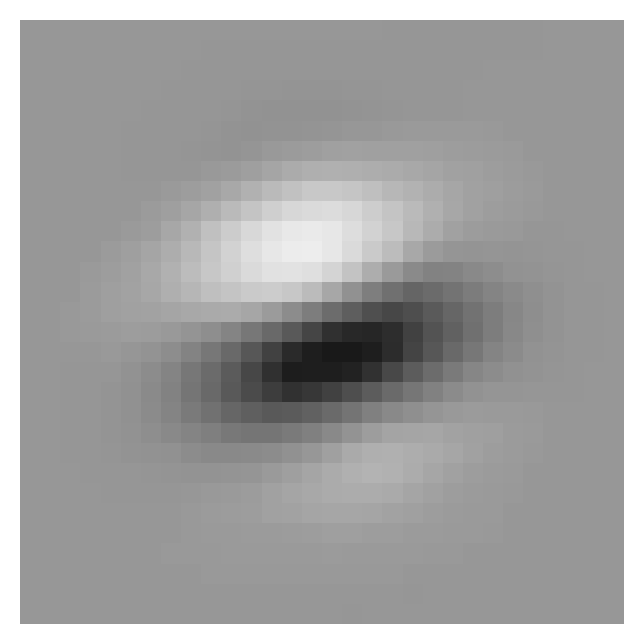

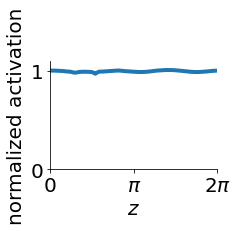

In [34]:
cell_name = f'2d_with_1d/temp_' + str(temperature)
with torch.no_grad():
    # plot flat
    n = 9
    grid = torch.linspace(0, 2*np.pi, n+1, )[:n].reshape(n, 1).to(device)
    encoding_model.eval()
    img_pre, img_post, acts, _ = forward(grid, cppn, img_transforms, encoding_model=encoding_model)
    name = "/project/plots/1D/"
    path = name + cell_name + "/flat_image/"
    os.makedirs(path, exist_ok=True)
    extreme = torch.max(torch.abs(img_post))
    plot_filters(img_post, nrow=n,  vmin=-extreme, vmax=extreme, cmap='Greys_r' )
    plt.axis('off')
    plt.savefig(f'{path}/flat.png', bbox_inches='tight', pad_inches = 0)

    # plot in circle
    def arrangeImagesInCircle(masterImage, imagesToArrange):
        imgWidth, imgHeight = masterImage.size
        diameter = min(
            imgWidth  - max(img.size[0] for img in imagesToArrange),
            imgHeight - max(img.size[1] for img in imagesToArrange)
        )
        radius = diameter / 2
        circleCenterX = imgWidth  / 2
        circleCenterY = imgHeight / 2
        theta = 2*math.pi / len(imagesToArrange)
        for i, curImg in enumerate(imagesToArrange):
            angle = i * theta
            dx = int(radius * math.sin(angle))
            dy = -int(radius * math.cos(angle))
            pos = (
                int(circleCenterX + dx - curImg.size[0]/2),
                int(circleCenterY + dy - curImg.size[1]/2),
            )
            masterImage.paste(curImg, pos)
        return img

    grid = torch.linspace(0, 2*np.pi, 13, )[:12].reshape(12, 1).to(device)
    encoding_model.eval()
    img_pre, img_post, acts, _ = forward(grid, cppn, img_transforms, encoding_model=encoding_model)
    name = "/project/plots/1D/"
    path = name + cell_name 
    os.makedirs(path, exist_ok=True)
    for i in range(0, 12):
        plt.imshow(img_post.detach().cpu().numpy()[i, 0],  vmin=-extreme, vmax=extreme, cmap='Greys_r')
        plt.axis('off')
        plt.savefig(f'{path}/{i:02d}.png', bbox_inches='tight', pad_inches = 0)
    img = Image.new("RGB", (2800,2800), (255,255,255))
    folder = path + "/circle_image/"
    os.makedirs(folder, exist_ok=True)
    imageFilenames = glob.glob(f'{path}/*.png')
    imageFilenames = sorted(imageFilenames)
    images = [Image.open(filename) for filename in imageFilenames]
    img = arrangeImagesInCircle(img, images)
    img.save(f'{folder}/circle.png')

    # activation
    n = 100
    grid = torch.linspace(0, 2*np.pi, n+1 )[:n].reshape(n, 1).to(device)
    encoding_model.eval()
    img_pre, img_post, acts, _ = forward(grid, cppn, img_transforms, encoding_model=encoding_model)
    acts = acts/MEI_activation
    name = "/project/plots/1D/"
    path = name  + cell_name + "/activation/" 
    os.makedirs(path, exist_ok=True)
    fix, ax = plt.subplots(1, 1, figsize=(3,2))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    plt.ylabel('normalized activation')
    plt.xlabel(r'$z$')
    ax.hlines(1, 0, 2*np.pi, linewidth=1)
    ax.plot(grid.detach().cpu().squeeze().numpy(), acts.detach().cpu().squeeze().numpy(),  linewidth=4)
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0,np.pi, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi$', r'2$\pi$'])
    plt.savefig(path + 'act.svg',  bbox_inches='tight', transparent=False)
    # plt.show()